In [1]:
import sys

sys.path.append('/home/caihuaiguang/DSG/pytorch-shapley-cam')

# 验证路径是否已添加
print(sys.path)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4" 



['/media/caihuaiguang/miniconda3/envs/cords/lib/python38.zip', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/lib-dynload', '', '/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages', '/home/caihuaiguang/DSG/InfoBatch', '/home/caihuaiguang/DSG/pytorch-shapley-cam']


In [2]:
# import warnings
# warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import torch
import timm
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from pytorch_grad_cam.metrics.road import ROADLeastRelevantFirstAverage, ROADMostRelevantFirstAverage
from pytorch_grad_cam.metrics.road import ROADCombined
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget, ClassifierOutputLnSoftmaxTarget,  ClassifierOutputEntropy, ClassifierOutputReST
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.metrics.ADCC import ADCC
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenGradCAM, LayerCAM, AblationCAM, RandomCAM, ShapleyCAM, ShapleyCAM_mean, ShapleyCAM_hires, GradCAMElementWise, HiResCAM, XGradCAM


In [3]:

model = models.resnet18(pretrained=True)
reshape_transform = None
# target_layers = [model.layer4[-1].relu]
target_layers = [model.layer4[-1]]

/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/caihuaiguang/miniconda3/envs/cords/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# model.eval()
# model = model.cuda()

# # Showing the metrics on top of the CAM : 
# def visualize_score(visualization, name, adcc, avg_drop, coherency, complexity, IC, ADD ):
#     visualization = cv2.putText(visualization, name, (10, 20), 
#                                 cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
#     # visualization = cv2.putText(visualization, f"ADCC: {adcc:.5f}", (10, 40), 
#     #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
#     # visualization = cv2.putText(visualization, f"AD: {avg_drop:.5f}", (10, 55), 
#     #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
#     # visualization = cv2.putText(visualization, f"Coherency: {coherency:.5f}", (10, 70), 
#     #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
#     # visualization = cv2.putText(visualization, f"Complexity: {complexity:.5f}", (10, 85), 
#     #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
#     # visualization = cv2.putText(visualization, f"IC: {IC:.5f}", (10, 100), 
#     #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
#     # visualization = cv2.putText(visualization, f"ADD: {ADD:.5f}", (10, 115), 
#     #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
#     return visualization
    
# def benchmark(_img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=None):
#     methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("HiResCAM", HiResCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("GradCAM-E", GradCAMElementWise(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("LayerCAM", LayerCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("XGradCAM", XGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("ScoreCAM", ScoreCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("ShapleyCAM", ShapleyCAM_mean(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("ShapleyCAM-H", ShapleyCAM_hires(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("ShapleyCAM-E", ShapleyCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("AblationCAM", AblationCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)),
#                ("RandomCAM", RandomCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform))]

#     cam_metric = ADCC()
#     # targets = [ClassifierOutputTarget(category)]
#     # targets = [ClassifierOutputSoftmaxTarget(category)]
#     # targets = [ClassifierOutputLnSoftmaxTarget(category)]
#     # targets = [ClassifierOutputEntropy(category)]
#     targets = [ClassifierOutputReST(category)]
    
#     metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
#     visualizations = []
#     for name, cam_method in methods:
#         attributions = cam_method(input_tensor=input_tensor, 
#                                     targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
#         attribution = attributions[0, :]   
#         adcc, avg_drop, coherency, complexity, inc, dropindeletion   =cam_metric(input_tensor,attributions,targets,metric_targets,model, cam_method)
#         visualization = show_cam_on_image(_img_example, attribution, use_rgb=True)
#         visualization = visualize_score(visualization, name, adcc[0], avg_drop[0], coherency[0], complexity[0], inc[0], dropindeletion[0] )
#         visualizations.append(visualization)
#     return Image.fromarray(np.hstack(visualizations))


In [5]:
model.eval()
model = model.cuda()

# Showing the metrics on top of the CAM : 
def visualize_score(visualization, name, adcc, avg_drop, coherency, complexity, IC, ADD ):
    visualization = cv2.putText(visualization, name, (5, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{adcc:.5f}", (150, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    # visualization = cv2.putText(visualization, f"AD: {avg_drop:.5f}", (10, 55), 
    #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    # visualization = cv2.putText(visualization, f"Coherency: {coherency:.5f}", (10, 70), 
    #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    # visualization = cv2.putText(visualization, f"Complexity: {complexity:.5f}", (10, 85), 
    #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    # visualization = cv2.putText(visualization, f"IC: {IC:.5f}", (10, 100), 
    #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    # visualization = cv2.putText(visualization, f"ADD: {ADD:.5f}", (10, 115), 
    #                             cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)    
    return visualization
    
def benchmark(_img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=None):
    method=  GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

    cam_metric = ADCC()
    targets_all = [[ClassifierOutputTarget(category)], [ClassifierOutputSoftmaxTarget(category)], [ClassifierOutputReST(category)]]
    
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]
    
    visualizations = []
    name = "GradCAM"
    for targets in targets_all:
        attributions = method(input_tensor=input_tensor, 
                                    targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]   
        adcc, avg_drop, coherency, complexity, inc, dropindeletion   =cam_metric(input_tensor,attributions,targets,metric_targets,model, method)
        visualization = show_cam_on_image(_img_example, attribution, use_rgb=True)
        visualization = visualize_score(visualization, name, adcc[0], avg_drop[0], coherency[0], complexity[0], inc[0], dropindeletion[0] )
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))


In [6]:
# https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/
# using this link to get label name from ID (start from 0) 

In [7]:
img_example = np.array(Image.open("./ILSVRC2012_val_00022113.JPEG"))


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()

model.eval()
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
_, predicted_min = torch.min(outputs.data, 1)
outputs = torch.softmax(outputs,dim=1)
# 获取前5个最高概率的标签及其对应的索引
top5_probs, top5_indices = torch.topk(outputs, 5, dim=1)

# 获取前5个最低概率的标签及其对应的索引
bottom5_probs, bottom5_indices = torch.topk(outputs, 5, dim=1, largest=False)

# 打印前5个最高概率的标签和对应概率
print("Top 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {top5_indices[i][j].item()}, Probability: {top5_probs[i][j].item()}")

# 打印前5个最低概率的标签和对应概率
print("\nLowest 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {bottom5_indices[i][j].item()}, Probability: {bottom5_probs[i][j].item()}")

Top 5 labels and probabilities for each example:
Label: 29, Probability: 1.0
Label: 1, Probability: 1.3786302766050085e-08
Label: 26, Probability: 1.13381837252291e-08
Label: 27, Probability: 1.838999508230188e-09
Label: 552, Probability: 5.529540159088242e-10

Lowest 5 labels and probabilities for each example:
Label: 293, Probability: 6.872567563863006e-19
Label: 920, Probability: 7.970797685561644e-19
Label: 423, Probability: 9.485400025334389e-19
Label: 386, Probability: 2.64902605936637e-18
Label: 807, Probability: 3.3122208038177506e-18


/home/caihuaiguang/DSG/pytorch-shapley-cam/pytorch_grad_cam/metrics/ADCC.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = attr_method(torch.tensor(explanation_map), targets)


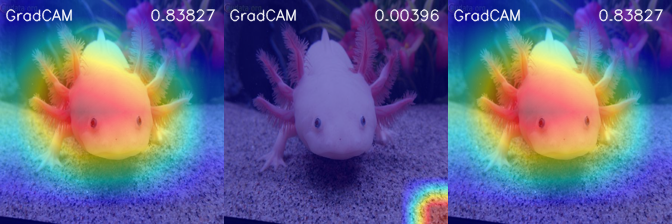

In [8]:
## mul
img_example = np.array(Image.open("./ILSVRC2012_val_00022113.JPEG"))
category = 29 # 	axolotl, mud puppy, Ambystoma mexicanum


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()
np.random.seed(42)
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

In [9]:
## mul
# img_example = np.array(Image.open("./ILSVRC2012_val_00023935.JPEG")) 
# img_example = np.array(Image.open("./ILSVRC2012_val_00007197.JPEG")) 
# img_example = np.array(Image.open("./ILSVRC2012_val_00022113.JPEG")) 
img_example = np.array(Image.open("../examples/both.png")) 


img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model.cuda()
input_tensor = input_tensor.cuda()

model.eval()
outputs = model(input_tensor)
_, predicted = torch.max(outputs.data, 1)
_, predicted_min = torch.min(outputs.data, 1)
outputs = torch.softmax(outputs,dim=1)
# 获取前5个最高概率的标签及其对应的索引
top5_probs, top5_indices = torch.topk(outputs, 5, dim=1)

# 获取前5个最低概率的标签及其对应的索引
bottom5_probs, bottom5_indices = torch.topk(outputs, 5, dim=1, largest=False)

# 打印前5个最高概率的标签和对应概率
print("Top 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {top5_indices[i][j].item()}, Probability: {top5_probs[i][j].item()}")

# 打印前5个最低概率的标签和对应概率
print("\nLowest 5 labels and probabilities for each example:")
for i in range(outputs.size(0)): 
    for j in range(5):
        print(f"Label: {bottom5_indices[i][j].item()}, Probability: {bottom5_probs[i][j].item()}")

Top 5 labels and probabilities for each example:
Label: 242, Probability: 0.42613548040390015
Label: 243, Probability: 0.26545336842536926
Label: 282, Probability: 0.17505350708961487
Label: 292, Probability: 0.09369010478258133
Label: 180, Probability: 0.013898419216275215

Lowest 5 labels and probabilities for each example:
Label: 986, Probability: 1.8018024138671818e-12
Label: 131, Probability: 3.2152841587113068e-12
Label: 135, Probability: 3.735661519704836e-12
Label: 128, Probability: 5.8647479234119615e-12
Label: 320, Probability: 7.119120397358625e-12


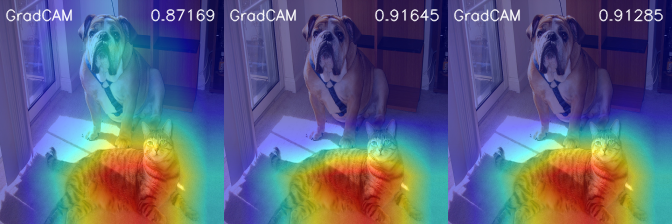

In [10]:
category = 282 # tiger cat
model.cuda()
input_tensor = input_tensor.cuda()
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)

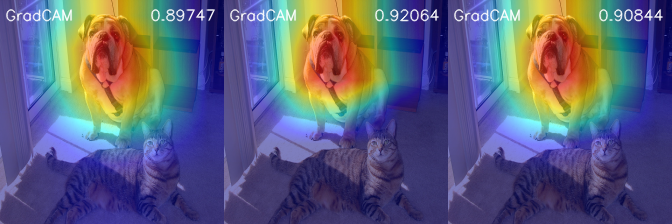

In [11]:

# cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# img_example = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))

img_example = np.array(Image.open("../examples/both.png")) 

img_example = cv2.resize(img_example, (224, 224))

category = 242 # boxer


# img_example = np.array(Image.fromarray(img_example).resize((224, 224)))
img_example = np.float32(img_example) / 255
input_tensor = preprocess_image(img_example, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model.cuda()
input_tensor = input_tensor.cuda()
benchmark(img_example, input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category= category)